In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, in_context_from_samples, test_prompt_from_samples, gpt_prediction, eval_response, results_path

In [2]:
output_dir = results_path / "sentence_caps"
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 67,
 'all_upper': 59,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'start_cap': 133,
 'start_lower': 67,
 'start_the': 57}


In [3]:
# datasets: all upper vs lower; starts with a capital vs not; has a capital vs not
# even vs odd counts; even vs odd length w/ all upper vs lower-->even mixed, odd mixed
# fragments vs sentence; just subject/verb fragments vs all
# nature vs rest
# contains a proper noun
tags_true = ["all_upper"]
tags_false = ["all_lower"]
tags_common = ["sentence", "shared_sample"]
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common)

In [4]:
pprint(positives)

[{'input': 'THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'odd_words',
           'start_the',
           'gpt4']},
 {'input': 'TODAY IS A BEAUTIFUL DAY.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'odd_words',
           'gpt4']},
 {'input': 'I LOVE TO TRAVEL AND EXPLORE NEW PLACES.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'even_words',
           'gpt4']},
 {'input': 'PYTHON IS A POPULAR PROGRAMMING LANGUAGE.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'even_words',
           'gpt4',
           'proper_noun']},
 {'input': 'THE SUN SETS IN THE WEST.',
  'label': True,
  'tags': ['star

In [20]:
pprint(negatives)

[{'input': 'the quick brown fox jumps over the lazy dog.',
  'label': False,
  'tags': ['shared_sample',
           'sentence',
           'nature',
           'odd_words',
           'start_the',
           'all_lower',
           'start_lower',
           'gpt4']},
 {'input': 'today is a beautiful day.',
  'label': False,
  'tags': ['all_lower',
           'shared_sample',
           'sentence',
           'nature',
           'odd_words',
           'start_lower',
           'gpt4']},
 {'input': 'i love to travel and explore new places.',
  'label': False,
  'tags': ['all_lower',
           'shared_sample',
           'sentence',
           'even_words',
           'start_lower',
           'gpt4']},
 {'input': 'python is a popular programming language.',
  'label': False,
  'tags': ['all_lower',
           'shared_sample',
           'sentence',
           'even_words',
           'start_lower',
           'gpt4',
           'proper_noun']},
 {'input': 'the sun sets in the west.',


In [5]:
samples_per_label = 1

positives = sorted(positives, key=lambda x: x["input"])
negatives = sorted(negatives, key=lambda x: x["input"])
in_context_samples = positives[:samples_per_label] + negatives[:samples_per_label]
in_context_prompt = in_context_from_samples(in_context_samples)
with open(output_dir / "in_context_prompt.txt", "w") as f:
    f.write(in_context_prompt)

test_positives = positives[samples_per_label:]
test_negatives = negatives[samples_per_label:]
test_prompt, test_samples = test_prompt_from_samples(test_positives, test_negatives)
with open(output_dir / "test_prompt.txt", "w") as f:
    f.write(test_prompt)
json.dump(test_samples, open(output_dir / "test_samples.json", "w"), indent=2)

In [6]:
temperatures = [0.1, 0.5, 1, 1.25, 1.5, 2]
response_jsons = []
in_context_prompt = open(output_dir / "in_context_prompt.txt").read()
test_prompt = open(output_dir / "test_prompt.txt").read()
test_samples = json.load(open(output_dir / "test_samples.json"))
for t in temperatures:
    response_json = gpt_prediction(in_context_prompt, test_prompt, temperature=t, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{t}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:87: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:88: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:91: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:92: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")
/Users/ishangaur/classification-faithfulness/utils.py:87: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfuln

In [7]:
temperatures = [0.1, 0.5, 1, 1.25, 1.5, 2]
response_jsons = [json.load(open(output_dir / f"response_{t}.json")) for t in temperatures]
test_samples = json.load(open(output_dir / "test_samples.json"))

results = []
responses = []
for r in response_jsons:
    print(r)
    response, result = eval_response(r, test_samples)
    results.append(result)
    responses.append(response)

[{'input': 'the ocean waves crash against the shore.', 'label': False}, {'input': 'science and technology are driving innovation.', 'label': False}, {'input': 'THE EARTH ROTATES ON ITS AXIS.', 'label': True}, {'input': 'THE STARS TWINKLE IN THE NIGHT SKY.', 'label': True}, {'input': 'the moonlight casts a glow over the night.', 'label': False}, {'input': 'READING OPENS DOORS TO NEW WORLDS.', 'label': True}, {'input': 'success is a journey, not a destination.', 'label': False}, {'input': 'today is a beautiful day.', 'label': False}, {'input': 'HEALTHY HABITS LEAD TO A HAPPY LIFE.', 'label': True}, {'input': 'THE OCEAN WAVES CRASH AGAINST THE SHORE.', 'label': True}, {'input': 'the mountains are majestic and grand.', 'label': False}, {'input': 'THE MOUNTAINS ARE MAJESTIC AND GRAND.', 'label': True}, {'input': 'happiness is a warm cup of tea.', 'label': False}, {'input': 'SUCCESS IS A JOURNEY, NOT A DESTINATION.', 'label': True}, {'input': 'THE MOONLIGHT CASTS A GLOW OVER THE NIGHT.', 'la

In [8]:
for t, r in zip(temperatures, results):
    r["temp"] = t
pprint(results)

[{'accuracy': 1.0,
  'correct': 40,
  'corrupted': 0,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 0.1,
  'total': 40},
 {'accuracy': 1.0,
  'correct': 40,
  'corrupted': 0,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 0.5,
  'total': 40},
 {'accuracy': 1.0,
  'correct': 40,
  'corrupted': 0,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 1,
  'total': 40},
 {'accuracy': 1.0,
  'correct': 40,
  'corrupted': 0,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 1.25,
  'total': 40},
 {'accuracy': 1.0,
  'correct': 40,
  'corrupted': 0,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 1.5,
  'total': 40},
 {'accuracy': 1.0,
  'correct': 40,
  'corrupted': 0,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 2,
  'total': 40}]


In [9]:
if not output_dir.exists():
    output_dir.mkdir()
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

      correct  mismatch  incorrect  corrupted  total
temp                                                
0.10       40         0          0          0     40
0.50       40         0          0          0     40
1.00       40         0          0          0     40
1.25       40         0          0          0     40
1.50       40         0          0          0     40
2.00       40         0          0          0     40


<Axes: xlabel='temp'>

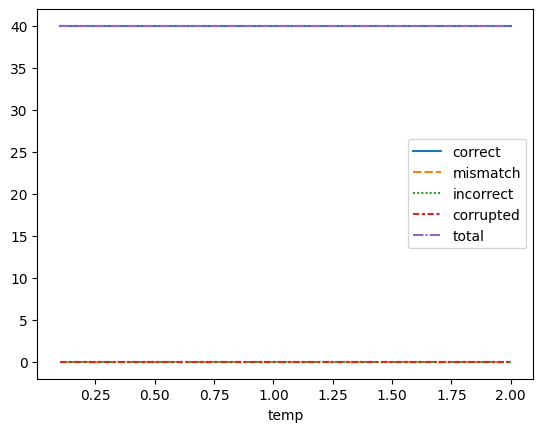

In [10]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
df = df.sort_values(by=["temp"])
df.set_index("temp", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Count")